# **Multivariate Time Series Transformer**

![image.png](attachment:c10fbf29-6619-4254-88ca-134b7a0c39f2.png)



In [2]:
pip install --quiet git+https://github.com/IBM/tsfm.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install --quiet transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import PatchTSTConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset

## Import packages

In [ ]:
# Standard

import os



# Third Party

from transformers import (

    EarlyStoppingCallback,

    PatchTSTConfig,

    PatchTSTForPrediction,

    set_seed,

    Trainer,

    TrainingArguments,

)

import numpy as np

import pandas as pd



# First Party

from tsfm_public.toolkit.dataset import ForecastDFDataset

from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

from tsfm_public.toolkit.util import select_by_index



# supress some warnings

import warnings



#warnings.filterwarnings("ignore", module="torch")

 ### Set seed

In [ ]:
set_seed(2023)

## Load data

In [ ]:
# Parameters

dataset_path = "/kaggle/input/stock-market/NVDA_ticker.csv"

timestamp_column = 'Date'

id_columns = []



context_length = 512

forecast_horizon = 30

patch_length = 16

num_workers = 16  # Reduce this if you have low number of CPU cores

batch_size = 64  # Adjust according to GPU memory

In [ ]:
data = pd.read_csv(

    dataset_path,

    parse_dates=['Date'],

)

forecast_columns = list(data.columns[1:])


In [ ]:
forecast_columns

['Close', 'High', 'Low', 'Volume']

## Split data

In [ ]:
# Preprocess the data

num_train = int(len(data) * 0.7)

num_test = int(len(data) * 0.2)

num_valid = len(data) - num_train - num_test

border1s = [

    0,

    num_train - context_length,

    len(data) - num_test - context_length,

]

border2s = [num_train, num_train + num_valid, len(data)]



train_start_index = border1s[0]  # None indicates beginning of dataset

train_end_index = border2s[0]



# we shift the start of the evaluation period back by context length so that

# the first evaluation timestamp is immediately following the training data

valid_start_index = border1s[1]

valid_end_index = border2s[1]



test_start_index = border1s[2]

test_end_index = border2s[2]



train_data = select_by_index(

    data,

    id_columns=id_columns,

    start_index=train_start_index,

    end_index=train_end_index,

)

valid_data = select_by_index(

    data,

    id_columns=id_columns,

    start_index=valid_start_index,

    end_index=valid_end_index,

)

test_data = select_by_index(

    data,

    id_columns=id_columns,

    start_index=test_start_index,

    end_index=test_end_index,

)



time_series_preprocessor = TimeSeriesPreprocessor(

    timestamp_column=timestamp_column,

    id_columns=id_columns,

    input_columns=forecast_columns,

    output_columns=forecast_columns,

    scaling=True,

)

time_series_preprocessor = time_series_preprocessor.train(train_data)

In [ ]:
# Number of total samples
total_samples = len(data)

# Calculate indices for train, valid, and test splits
num_train = int(total_samples * 0.7)  # 70%
num_valid = int(total_samples * 0.2)  # 20%
num_test = total_samples - num_train - num_valid  # Remaining samples

# Calculate index borders
border1s = [
    0,
    num_train,  # Start of validation right after training ends
    num_train + num_valid  # Start of testing right after validation ends
]

border2s = [num_train, num_train + num_valid, total_samples]  # End indices

train_start_index = border1s[0]
train_end_index = border2s[0]

valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

# Debugging: Print the calculated indices
print(f"Train indices: {train_start_index} to {train_end_index} (exclusive)")
print(f"Validation indices: {valid_start_index} to {valid_end_index} (exclusive)")
print(f"Test indices: {test_start_index} to {test_end_index} (exclusive)")

# Select the datasets
train_data = select_by_index(data, id_columns=id_columns, start_index=train_start_index, end_index=train_end_index)
valid_data = select_by_index(data, id_columns=id_columns, start_index=valid_start_index, end_index=valid_end_index)
test_data = select_by_index(data, id_columns=id_columns, start_index=test_start_index, end_index=test_end_index)



Train indices: 0 to 492 (exclusive)
Validation indices: 492 to 632 (exclusive)
Test indices: 632 to 704 (exclusive)


In [ ]:
# Check the shape of each dataset
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (492, 5)
Validation data shape: (140, 5)
Testing data shape: (72, 5)


## Preprocess the data

In [ ]:
# Preprocess the data
train_data = time_series_preprocessor.preprocess(train_data)
valid_data = time_series_preprocessor.preprocess(valid_data)
test_data = time_series_preprocessor.preprocess(test_data)

In [ ]:
# Create ForecastDFDataset for training, validation, and test
train_dataset = ForecastDFDataset(
    data=train_data,
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    target_columns=forecast_columns,  # Specify the target columns
    observable_columns=[],  # Specify any observable columns if needed
    control_columns=[],  # Specify any control columns if needed
    conditional_columns=[],  # Specify any conditional columns if needed
    static_categorical_columns=[],  # Specify static categorical columns if needed
    context_length=context_length,
    prediction_length=forecast_horizon,
    num_workers=num_workers,
)

valid_dataset = ForecastDFDataset(
    data=valid_data,
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    target_columns=forecast_columns,
    observable_columns=[],
    control_columns=[],
    conditional_columns=[],
    static_categorical_columns=[],
    context_length=context_length,
    prediction_length=forecast_horizon,
    num_workers=num_workers,
)

test_dataset = ForecastDFDataset(
    data=test_data,
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    target_columns=forecast_columns,
    observable_columns=[],
    control_columns=[],
    conditional_columns=[],
    static_categorical_columns=[],
    context_length=context_length,
    prediction_length=forecast_horizon,
    num_workers=num_workers,
)

## Setting up the parameters

The settings below control the different hyperparameters related to the architecture.

  - `num_input_channels`: the number of input channels (or dimensions) in the time series data. This is

    automatically set to the number for forecast columns.

  - `context_length`: As described above, the amount of historical data used as input to the model.

  - `patch_length`: The length of the patches extracted from the context window (of length `context_length`).

  - `patch_stride`: The stride used when extracting patches from the context window.

  - `random_mask_ratio`: The fraction of input patches that are completely masked for pretraining the model.

  - `d_model`: Dimension of the transformer layers.

  - `num_attention_heads`: The number of attention heads for each attention layer in the Transformer encoder.

  - `num_hidden_layers`: The number of encoder layers.

  - `ffn_dim`: Dimension of the intermediate (often referred to as feed-forward) layer in the encoder.

  - `dropout`: Dropout probability for all fully connected layers in the encoder.

  - `head_dropout`: Dropout probability used in the head of the model.

  - `pooling_type`: Pooling of the embedding. `"mean"`, `"max"` and `None` are supported.

  - `channel_attention`: Activate the channel attention block in the Transformer to allow channels to attend to each other.

  - `scaling`: Whether to scale the input targets via "mean" scaler, "std" scaler, or no scaler if `None`. If `True`, the

    scaler is set to `"mean"`.

  - `loss`: The loss function for the model corresponding to the `distribution_output` head. For parametric

    distributions it is the negative log-likelihood (`"nll"`) and for point estimates it is the mean squared

    error `"mse"`.

  - `pre_norm`: Normalization is applied before self-attention if pre_norm is set to `True`. Otherwise, normalization is

    applied after residual block.

  - `norm_type`: Normalization at each Transformer layer. Can be `"BatchNorm"` or `"LayerNorm"`.



For full details on the parameters, we refer to the [documentation](https://huggingface.co/docs/transformers/main/en/model_doc/patchtst#transformers.PatchTSTConfig).


In [ ]:
config = PatchTSTConfig(

    num_input_channels=len(forecast_columns),

    context_length=context_length,

    patch_length=patch_length,

    patch_stride=patch_length,

    prediction_length=forecast_horizon,

    random_mask_ratio=0.4,

    d_model=128,

    num_attention_heads=16,

    num_hidden_layers=3,

    ffn_dim=256,

    dropout=0.2,

    head_dropout=0.2,

    pooling_type=None,

    channel_attention=False,

    scaling="std",

    loss="mse",

    pre_norm=True,

    norm_type="batchnorm",

)

model = PatchTSTForPrediction(config)

In [ ]:
import torch


# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


## Train model


Next, we can leverage the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class to train the model based on the direct forecasting strategy. We first define the [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) which lists various hyperparameters for training such as the number of epochs, learning rate and so on.

In [ ]:
import os
import multiprocessing as mp
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

mp.set_start_method('spawn', force=True)

training_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/electricity/pretrain/output/",
    overwrite_output_dir=True,
    num_train_epochs=100,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=4,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/electricity/pretrain/logs/",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    label_names=["future_values"],
    run_name="my_experiment_run",
    log_level="error"  # Set verbosity to error level
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.0001,
)



trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    #compute_metrics=compute_metrics,
)

trainer.train()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,2.671900,37.988655
2,2.603300,37.628712
3,2.515500,37.272697
4,2.409100,36.919823
5,2.328000,36.567928
6,2.238700,36.217632
7,2.147300,35.868706
8,2.097000,35.520714
9,1.980800,35.173317
10,1.920500,34.825230


TrainOutput(global_step=100, training_loss=0.5271851750276982, metrics={'train_runtime': 4839.4353, 'train_samples_per_second': 0.021, 'train_steps_per_second': 0.021, 'total_flos': 647113113600.0, 'train_loss': 0.5271851750276982, 'epoch': 100.0})

## Evaluate the model



Next, we can leverage `trainer.evaluate()` to calculate test metrics. While this is not the target metric to judge in this task, it provides a reasonable check that the pretrained model has trained properly.

Note that the training and evaluation loss for `PatchTST` is the Mean Squared Error (MSE) loss. Hence, we do not separately compute the MSE metric in any of the following evaluation experiments.

In [ ]:
results = trainer.evaluate(test_dataset)

print("Test result:")

print(results)

Test result:
{'eval_loss': 14.166226387023926, 'eval_runtime': 14.1936, 'eval_samples_per_second': 0.07, 'eval_steps_per_second': 0.07, 'epoch': 100.0}


## Save model

In [ ]:
save_dir = "kaggle/working//model/pretrain/" # Path to save the model

os.makedirs(save_dir, exist_ok=True)

trainer.save_model(save_dir)

## Visualize the evaluation metrics

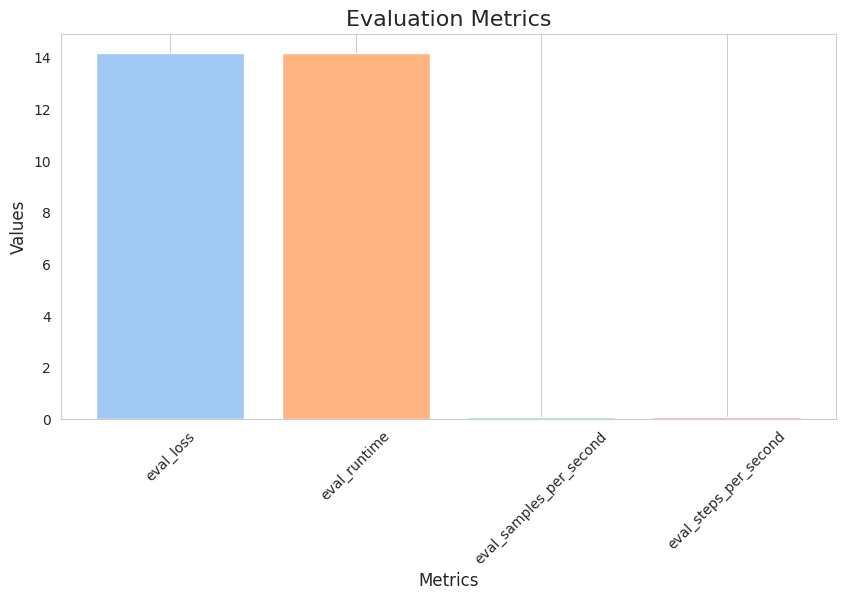

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

def plot_evaluation_metrics(results):
    metrics = {key: value for key, value in results.items() if 'eval_' in key}

    # Use pastel colors
    pastel_colors = sns.color_palette("pastel", len(metrics))

    plt.figure(figsize=(10, 5))
    plt.bar(metrics.keys(), metrics.values(), color=pastel_colors)
    plt.title('Evaluation Metrics', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Call the plotting function
plot_evaluation_metrics(results)
